## Data preprocessing

In diesem Notebook werden die Daten eingelesen und für die Training des Modells vorbereitet

In [297]:
import pandas as pd

In [298]:
data = pd.read_excel('data/original/Ein-Ausfahrten_Wildpark_Alle.xlsx')

Im ersten Schritt wird das Target standardisiert. Dazu wird eine neue Spalte 'Diff' erstellt, die die Differenz zwischen Ein- und Ausfahrten beinhaltet.

In [299]:
# Berechnung der Differenz zwischen Ein- und Ausfahrten
data['Differenz'] = data['Kurzparker Einfahrten'] - data['Kurzparker Ausfahrten']

Eine neue Spalte 'Auslastung' wird erstellt. Dazu werden die Einfahrten in die neue Spalte übernommen.

In [300]:
# Erstellung der Spalte 'Auslastung'
data['Auslastung'] = data['Kurzparker Einfahrten']

Im nächsten Schritt wird für jeden Tag an dem es einen positiven Überhang an Ein- und Ausfahrten gab, jener Überhang zu den Einfahrten des darauffolgenden Tages 

In [301]:
# Iteration über die Daten
for i in range(len(data)):
    # Wenn die Differenz größer als 0 ist und die letzte Zeile noch nicht erreicht ist
    if data['Differenz'][i] > 0 and i != len(data)-1:
        # Der positive Überhang wird zu den Einfahrten des darauffolgenden Tages addiert
        data.loc[i+1, 'Auslastung'] += data['Differenz'][i]
    # Wenn die Differenz kleiner als 0 ist 
    elif data['Differenz'][i] < 0:
        # Der negative Überhang wird als absolute Zahl zu den Ausfahrten des Tages addiert
        data.loc[i, 'Auslastung'] += abs(data['Differenz'][i])

In [302]:
# Die Spalten 'Kurzparker Einfahrten', 'Kurzparker Ausfahrten' und Differenz werden gelöscht
data = data.drop(['Kurzparker Einfahrten', 'Kurzparker Ausfahrten', 'Differenz', 'PName'], axis=1)

# Die Spalte 'Tag' wird in 'Datum' umbenannt
data = data.rename(columns={'Tag': 'Datum'})

In [303]:
data.head(10)

,Datum,Auslastung
0,2015-01-01,100
1,2015-01-02,50
2,2015-01-03,53
3,2015-01-04,151
4,2015-01-05,99
5,2015-01-06,185
6,2015-01-07,48
7,2015-01-08,40
8,2015-01-09,38
9,2015-01-10,199


Das Target 'Auslastung' bleibt vorerst unverändert. Als Nächstes werden die Features erstellt. Dazu wird jedem Datum der entsprechende Wochentag zugeordnet. Um die Wochentage herauszufinden, wird die Spalte 'Datum' in ein DateTime-Objekt umgewandelt und anschließend der Wochentag extrahiert. Dazu wird die Funktion `dt.dayofweek` von Pandas verwendet.

In [304]:
# Hinzufügen des Wochentags als numerischer Wert (0 = Montag, 6 = Sonntag)
data['Datum'] = pd.to_datetime(data['Datum'])
data['Wochentag'] = data['Datum'].dt.dayofweek

Als Nächstes werden die Wochentage in Sinus- und Cosinuswerte umgewandelt. Dies hat den Vorteil, dass die Wochentage zyklisch dargestellt werden und die Distanz zwischen den Wochentagen korrekt dargestellt wird. Dazu wird die Funktion `FunctionTransformer` von Scikit-Learn verwendet. Die Funktion `sin_transformer` und `cos_transformer` erstellen jeweils eine neue Spalte für den Sinus und Cosinus Wert des Wochentags. Die folgenden Funktionen zur Umwandlung der Wochentage in Sinus- und Cosinuswerte und zur Visualisierung wurden von [hier](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html) übernommen.

In [305]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

In [306]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [307]:
data["Wochentag_sin"] = sin_transformer(7).fit_transform(data[["Wochentag"]])
data["Wochentag_cos"] = cos_transformer(7).fit_transform(data[["Wochentag"]])

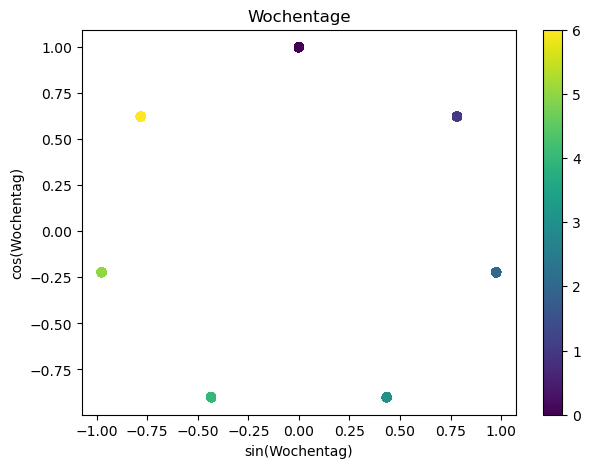

In [308]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(data["Wochentag_sin"], data["Wochentag_cos"], c=data["Wochentag"])
ax.set(
    xlabel="sin(Wochentag)",
    ylabel="cos(Wochentag)",
    title = "Wochentage"
)
_ = fig.colorbar(sp)

Als nächstes weird unterschieden, ob es sich um einen Wochenendtag handelt oder nicht. Dazu wird eine neue Spalte 'Wochenende' erstellt. dazu wird On-Hot-Encoding verwendet.

In [309]:
# Hinzufügen der Spalte 'Wochenende'
data['Wochenende'] = data['Wochentag'].apply(lambda x: 1 if x >= 5 else 0)

In [310]:
# Die Spalte 'Wochentag' wird nicht mehr benötigt und wird gelöscht
data = data.drop(['Wochentag'], axis=1)

Des Weiteren müssen die gesetzlichen Feiertage berücksichtigt werden. Es wird eine neue Spalte 'Feiertag' erstellt, die durch One-Hot-Encoding angibt, ob es sich um einen Feiertag handelt oder nicht.

In [311]:
Feiertage = [
    {'Month': 1, 'Day': 1, 'Name': 'Neujahrstag'},
    {'Month': 1, 'Day': 6, 'Name': 'Heilige Drei Könige'},
    {'Month': 3, 'Day': 19, 'Name': 'Landespatron Vorarlberg (Hl. Josef)'},
    {'Month': 5, 'Day': 1, 'Name': 'Staatsfeiertag'},
    {'Month': 8, 'Day': 15, 'Name': 'Mariä Himmelfahrt'},
    {'Month': 10, 'Day': 26, 'Name': 'Nationalfeiertag'},
    {'Month': 11, 'Day': 1, 'Name': 'Allerheiligen'},
    {'Month': 12, 'Day': 8, 'Name': 'Mariä Empfängnis'},
    {'Month': 12, 'Day': 25, 'Name': 'Christtag'},
    {'Month': 12, 'Day': 26, 'Name': 'Stefanitag'}
]

In [312]:
# Hinzufügen der Spalte 'Feiertag'
data['Feiertag'] = data['Datum'].apply(lambda x: 1 if any((x.month == f['Month'] and x.day == f['Day']) for f in Feiertage) else 0)

In [313]:
data.head(10)

,Datum,Auslastung,Wochentag_sin,Wochentag_cos,Wochenende,Feiertag
0,2015-01-01,100,0.433884,-0.900969,0,1
1,2015-01-02,50,-0.433884,-0.900969,0,0
2,2015-01-03,53,-0.974928,-0.222521,1,0
3,2015-01-04,151,-0.781831,0.623490,1,0
4,2015-01-05,99,0.000000,1.000000,0,0
5,2015-01-06,185,0.781831,0.623490,0,1
6,2015-01-07,48,0.974928,-0.222521,0,0
7,2015-01-08,40,0.433884,-0.900969,0,0
8,2015-01-09,38,-0.433884,-0.900969,0,0
9,2015-01-10,199,-0.974928,-0.222521,1,0
